# Relatório de Agrupamento - Consumo Diário de Água em Produção Animal

> Este relatório apresenta uma análise de agrupamento com base no consumo diário de água por lotes de animais.

## Informações do Aluno

* **Nome:** Igor Lima Rocha
* **Matrícula:** 201910282
* **E-mail:** ilrocha.cic@uesc.br

## 1. Introdução

O objetivo é agrupar os lotes com base em padrões de consumo de água ao longo de um período definido. O desafio inclui o tratamento de dados faltantes e a seleção de um método de agrupamento adequado. Utilizaremos duas bases de dados: uma contendo o consumo diário de água e outra com informações adicionais dos lotes. As métricas de avaliação e os métodos de visualização serão detalhados ao longo deste relatório.

## 2. Carregamento dos Dados

Agora, vamos carregar o conjunto de dados em um DataFrame para começar nossa análise.

In [9]:
import pandas as pd

# Carregar dados
water_flow_df = pd.read_csv('water_flow_by_day.csv')
lots_df = pd.read_csv('lots_filtered.csv')

# Visualizar as primeiras linhas dos dados
print(water_flow_df.head())
print(lots_df.head())

   _  lot_day season   age  per_capita  lot_id prod_id
0  0        3    inv  23.0    0.346664  615812     n_3
1  1        4    inv  24.0    0.708991  615812     n_3
2  2        5    inv  25.0    0.936537  615812     n_3
3  3        6    inv  26.0    0.722595  615812     n_3
4  4        7    inv  27.0    0.744303  615812     n_3
   _  lot_id  total_input  mortality  input_age  output_age  input_weight  \
0  0  615812        10536   2.107062       21.0        67.0      7.640801   
1  1  542538         6243   3.315714       21.0        86.0      7.655272   
2  2  542539         5926   3.307459       21.0        80.0      7.582211   
3  3  562033         5931   8.497724       21.0        84.0      7.329978   
4  4  592317         6169   5.641109       21.0        90.0      7.547541   

   output_weight  daily_weight_gain  daily_feed_per_animal  \
0      22.516912           0.323394               0.459359   
1      24.382962           0.257349               0.287582   
2      24.420199     

Com os DataFrames carregados, podemos prosseguir para as próximas etapas.

## 3. Limpeza dos Dados

### 3.1 Tratamento de Valores Ausentes

Optamos por descartar registros com dados faltantes nas colunas `daily_feed_per_animal` e `adjusted_feed_conversion_ratio`, pois são importantes para análises mais detalhadas e podem não estar diretamente relacionados ao consumo de água.

In [10]:
# Tratando dados faltantes na base 'lots_filtered.csv'
lots_df.dropna(subset=['daily_feed_per_animal', 'adjusted_feed_conversion_ratio'], inplace=True)

# Verificando se ainda existem dados faltantes
print(lots_df.isnull().sum())

_                                 0
lot_id                            0
total_input                       0
mortality                         0
input_age                         0
output_age                        0
input_weight                      0
output_weight                     0
daily_weight_gain                 0
daily_feed_per_animal             0
adjusted_feed_conversion_ratio    0
days_in_stage                     0
dtype: int64


Para a outra base de dados preenchemos os valores faltantes usando a interpolação linear, que é adequada para séries temporais contínuas como o nosso conjunto de dados.


In [22]:
# Preenchendo os valores faltantes com interpolação
water_flow_df.interpolate(method='linear', inplace=True)

# Verificando novamente os dados faltantes após interpolação
print(water_flow_df.isnull().sum())

_             0
lot_day       0
season        0
age           0
per_capita    0
lot_id        0
prod_id       0
cluster       0
dtype: int64


## 4. Agrupamento

### 4.1 Preparação dos dados

Para o agrupamento, focamos nos dados de consumo diário de água, removendo colunas não relacionadas a este consumo, como identificadores e características dos lotes.

In [25]:
from sklearn.preprocessing import StandardScaler

# Selecionando as características para o agrupamento
X = water_flow_df.drop(['season', 'age', 'lot_id', 'prod_id'], axis=1)

# Escalando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 4.2 Determinação do Número de Clusters com o Método do Cotovelo

Utilizamos o método do cotovelo para determinar o número ideal de clusters. Este método envolve a execução do K-Means várias vezes com um número crescente de clusters e a escolha do número de clusters no ponto onde a soma dos quadrados dos erros (SSE) começa a se achatar.

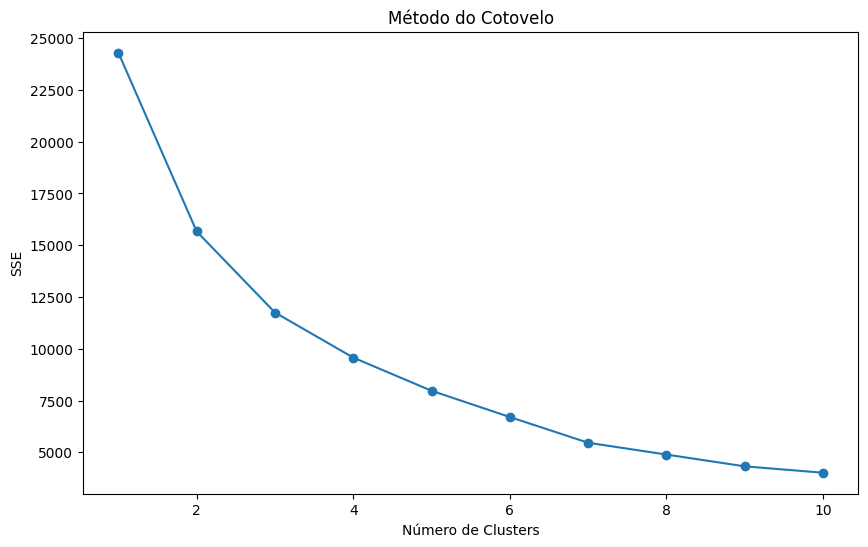

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determinando o número ideal de clusters usando o método do cotovelo
# Determinando o número ideal de clusters usando o método do cotovelo
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    sse[k] = kmeans.inertia_

# Plot do método do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.title('Método do Cotovelo')
plt.show()

### 4.3 Aplicação do K-Means e Visualização dos Clusters

Após determinar o número ideal de clusters, aplicamos o K-Means para segmentar os dados e visualizamos os resultados para entender os padrões de consumo de água entre os diferentes clusters.

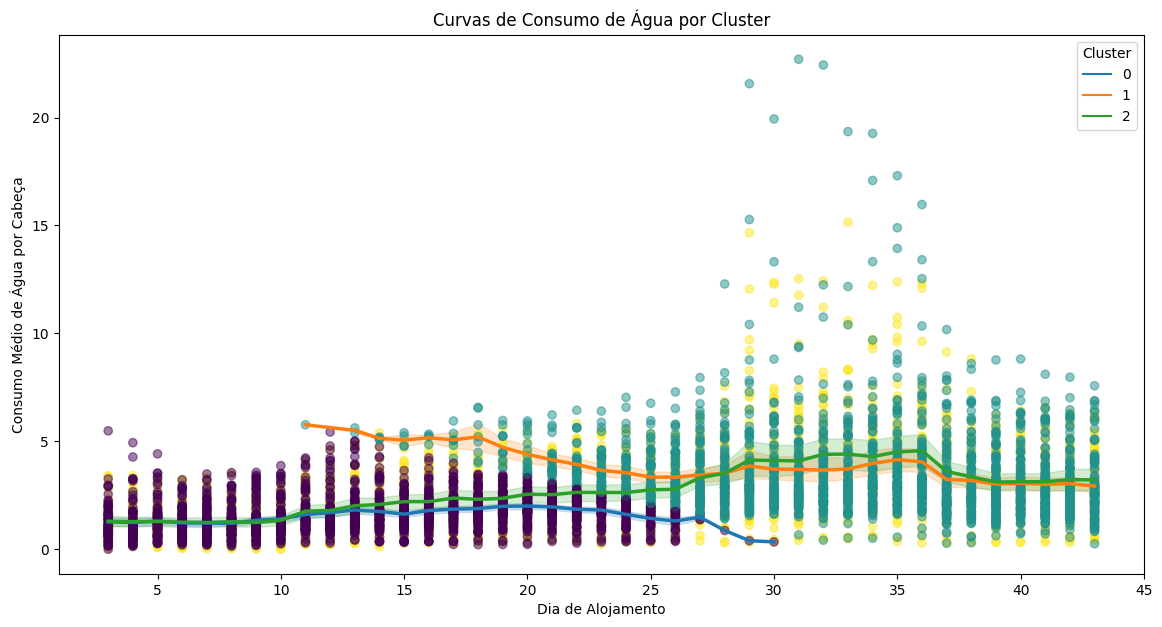

In [27]:
import seaborn as sns

# Aplicando o K-Means com o número ideal de clusters
k_ideal = 3  # Este valor deve ser ajustado com base no resultado do método do cotovelo
kmeans = KMeans(n_clusters=k_ideal, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
water_flow_df['cluster'] = clusters

# Plot das curvas de consumo para cada cluster
plt.figure(figsize=(14, 7))
sns.lineplot(x='lot_day', y='per_capita', hue='cluster', data=water_flow_df, palette='tab10', linewidth=2.5)
plt.scatter(water_flow_df['lot_day'], water_flow_df['per_capita'], c=water_flow_df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Curvas de Consumo de Água por Cluster')
plt.xlabel('Dia de Alojamento')
plt.ylabel('Consumo Médio de Água por Cabeça')
plt.legend(title='Cluster')
plt.show()

## 5. Visualização dos Centróides dos Clusters

Visualizamos os centróides de cada cluster, que representam o 'centro' dos padrões de consumo de água para os lotes dentro de cada cluster.


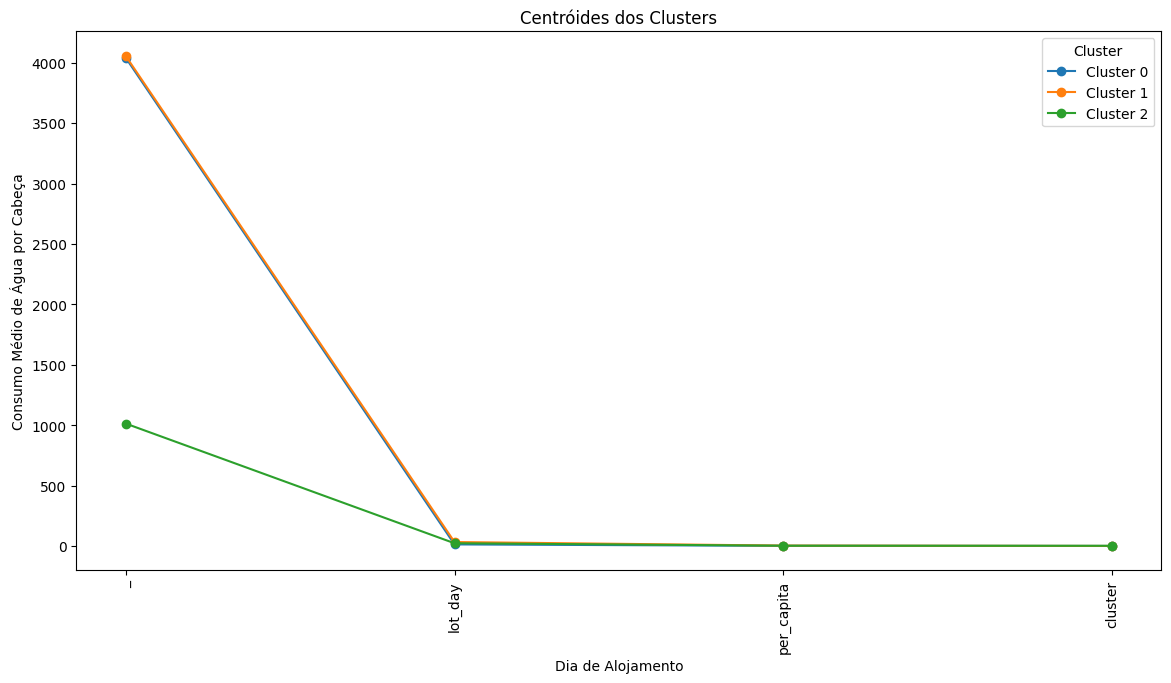

In [33]:
import numpy as np

# Primeiro, vamos determinar o número de características para os centróides
# O número de características deve ser o mesmo que o número de dias de alojamento usados no agrupamento
num_features = X.shape[1]  # Substitua X pelo DataFrame correto se necessário


# Agora, criamos um DataFrame para os centróides com a quantidade correta de linhas e colunas
centroids_df = pd.DataFrame(centroids_original_scale, columns=X.columns[:num_features])

# Adicionamos a sequência correta de dias ao DataFrame dos centróides
# O DataFrame dos centróides deve ter uma coluna para cada dia, portanto, não precisamos de uma coluna 'lot_day' separada
# Se X.columns não estiver em ordem ou faltar alguns dias, você precisará ajustar isso de acordo

# Plotando os centróides dos clusters
plt.figure(figsize=(14, 7))
# Aqui, cada linha do DataFrame dos centróides representa um centróide de cluster
# Iteramos sobre as linhas e plotamos cada centróide como uma linha no gráfico
for i in range(len(centroids_df)):
    plt.plot(X.columns, centroids_df.iloc[i, :], marker='o', label=f'Cluster {i}')
plt.title('Centróides dos Clusters')
plt.xlabel('Dia de Alojamento')
plt.ylabel('Consumo Médio de Água por Cabeça')
plt.legend(title='Cluster')
plt.xticks(rotation=90)  # Rotação dos ticks no eixo x para melhor visualização
plt.show()